<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-1/agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agent（智能体）

## 回顾

我们之前构建了一个“路由器”。

- 我们的聊天模型会根据用户输入，决定是否调用某个工具（tool）。
- 我们使用“条件边”（conditional edge）将流程路由到会调用工具的节点，或直接结束。

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## 目标

现在，我们把它扩展为一个通用的智能体架构。

在上面的路由器中，我们先调用模型；如果模型选择调用工具，我们会把工具的输出作为 `ToolMessage` 返回给用户。

但是，如果我们把这个 `ToolMessage` 再“传回给模型”会怎样？

这样模型就可以： (1) 继续调用其他工具；或 (2) 直接给出最终回答。

这正是 [ReAct](https://react-lm.github.io/)（一种通用智能体架构）的直觉：

- `act`：让模型调用特定工具
- `observe`：把工具输出反馈给模型
- `reason`：让模型基于工具输出进行推理，决定下一步（例如继续调用工具或直接回复）

这种[通用架构](https://blog.langchain.dev/planning-for-agents/)可适配多种类型的工具。

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [1]:
%%capture --no-stderr
# %pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7 langgraph-prebuilt==0.6.4

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


这里我们使用 [LangSmith](https://docs.smith.langchain.com/) 做[链路追踪](https://docs.smith.langchain.com/concepts/tracing)。

我们会把运行数据记录到名为 `langchain-academy` 的项目中。

**补充说明：**

要使用 LangSmith，你需要获取 `LANGSMITH_API_KEY`。请按照以下步骤操作：

1.  访问 [LangSmith 网站](https://smith.langchain.com/)。
2.  注册或登录你的账户。
3.  在设置中找到 API Keys 部分，创建并复制你的 API Key。
4.  将复制的 API Key 粘贴到下面的输入框中。

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY: ··········


In [4]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """将 a 与 b 相乘。

    参数:
        a: 第一个整数
        b: 第二个整数
    """
    return a * b

# 该函数会作为一个工具（tool）暴露给模型
def add(a: int, b: int) -> int:
    """将 a 与 b 相加。

    参数:
        a: 第一个整数
        b: 第二个整数
    """
    return a + b

def divide(a: int, b: int) -> float:
    """用 a 除以 b。

    参数:
        a: 被除数（整数）
        b: 除数（整数）
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")

# 在本笔记本中将并行工具调用关闭（parallel_tool_calls=False）。
# 原因：数学步骤通常是串行进行；同时此处有 3 个可做数学运算的工具。
# 提示：OpenAI 模型为提高效率默认支持并行工具调用，参考文档：
# https://python.langchain.com/docs/how_to/tool_calling_parallel/
# 你可以尝试打开并行看看模型在数学场景下的表现差异。
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

接下来创建我们的 LLM，并通过提示词（system prompt）明确本智能体的整体行为目标。

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# 系统消息：设定智能体的角色与目标
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# 节点（Node）：封装一次模型调用；将系统消息与历史消息一起传入模型
# 返回：在状态中追加一次模型输出（可能包含工具调用）
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

与之前相同，我们使用 `MessagesState` 并用工具列表定义一个 `Tools` 节点。

`Assistant` 节点就是绑定了工具的模型本身。

我们用 `Assistant` 与 `Tools` 两个节点来构建一张图（graph）。

添加一条 `tools_condition` 条件边：若 `Assistant` 的最新输出包含工具调用，则路由到 `Tools`；否则路由到 `END`。

现在增加一个新步骤：

把 `Tools` 节点再连接回 `Assistant`，形成一个循环。

- 在 `assistant` 节点执行后，`tools_condition` 会检查模型输出是否包含工具调用。
- 如果是工具调用，流程进入 `tools` 节点。
- `tools` 节点执行完毕后回到 `assistant`。
- 只要模型继续决定调用工具，这个循环就会持续。
- 如果模型决定不再调用工具，流程就会走向 `END`，整个过程结束。

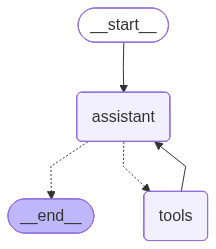

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# 图构建（Graph）
builder = StateGraph(MessagesState)

# 定义节点：实际执行工作的节点
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# 定义边：决定控制流如何流转
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # 若 assistant 的最新消息是工具调用 -> tools_condition 路由到 tools
    # 若 assistant 的最新消息不是工具调用 -> tools_condition 路由到 END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# 展示图结构
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [8]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_V0qXU0uQqi27StQqwiEAkHke)
 Call ID: call_V0qXU0uQqi27StQqwiEAkHke
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_0ZZ2yKpj9PvD9CybGelpyPIa)
 Call ID: call_0ZZ2yKpj9PvD9CybGelpyPIa
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_RpjZyTStHN5amkMXj0G0O6SK)
 Call ID: call_RpjZyTStHN5amkMXj0G0O6SK
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

## LangSmith

你可以在 LangSmith 中查看[执行轨迹（traces）](https://smith.langchain.com/o/7bfa9385-4ac5-468a-a06c-ffd7dbac42ec/projects/p/d0a1a7a3-9644-4271-82cb-ccadc3ab6969?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=66968bd4-8df4-4841-82f5-ec4ab9205a3b&peeked_trace=66968bd4-8df4-4841-82f5-ec4ab9205a3b)，以便调试与分析。

**运行结果截图**
![LangSmith 链路追踪结果](https://cdn.jsdelivr.net/gh/Fly0905/note-picture@main/imag/202509101720154.png)